In [1]:
data_dir = "/home/cadel/projects/thesis/UNSWThesis/data/completeness"

In [2]:
import os

with open(os.path.join(data_dir, "sandy", "ste08-syntenic-blocks-100.txt")) as f:
    sandy_blocks = [[int(x) for x in line.split(",")] for line in f]

with open(os.path.join(data_dir, "starling", "synteny", "blocks.txt")) as f:
    starling_blocks = [[int(x) for x in line.split(",")] for line in f] 
    
with open(os.path.join(data_dir, "sandy", "synteny_ste08_100bp_minimised.csv")) as f:
    min_sandy_blocks = [[int(x) for x in line.split(",")] for line in f]

with open(os.path.join(data_dir, "starling", "synteny", "blocks_minimised.txt")) as f:
    min_starling_blocks = [[int(x) for x in line.split(",")] for line in f] 

TypeError: unsupported operand type(s) for +: 'set' and 'int'

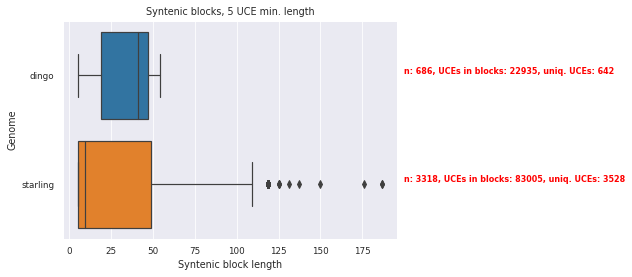

In [3]:
import pandas as pd
import seaborn as sns
import constants

sns.set_context(constants.sns_context)
sns.set_style(constants.sns_style)

df = pd.DataFrame.from_records([{"len": len(b), "genome": "dingo"} for b in sandy_blocks] + [{"len": len(b), "genome": "starling"} for b in starling_blocks])
bp = sns.boxplot(data=df,x="len", y="genome")
bp.set_xlabel("Syntenic block length")
bp.set_ylabel("Genome")
bp.set_title("Syntenic blocks, 5 UCE min. length")
bp.get_figure().savefig(os.path.join(constants.image_out_dir, "blocklen.pdf"))
ax = bp.get_xaxis()

counts = [len(sandy_blocks),len(starling_blocks)]
uces = [sum([len(x) for x in sandy_blocks]),sum([len(x) for x in starling_blocks])]
unique = [len(set([y for x in sandy_blocks for y in x])),len(set([y for x in starling_blocks for y in x]))]

for tick,label in zip(range(2),bp.get_xticklabels()):
    bp.text(200,
            tick,
            f"n: {counts[tick]}, UCEs in blocks: {uces[tick]}, uniq. UCEs: {unique[tick]}",
            verticalalignment='bottom',
            size='small',
            color='red',
            weight='semibold')


Text(0.5, 1.0, 'Minimal syntenic blocks, 5 UCE min. length')

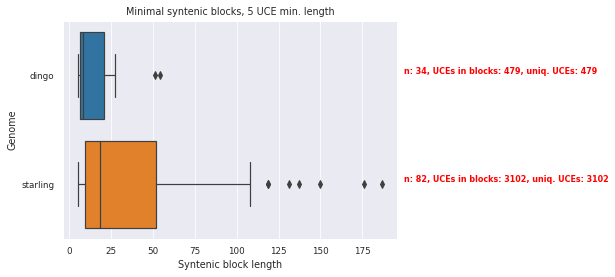

In [4]:
import matplotlib.pyplot as plt
plt.clf()
dfmin = pd.DataFrame.from_records([{"len": len(b), "genome": "dingo"} for b in min_sandy_blocks] + [{"len": len(b), "genome": "starling"} for b in min_starling_blocks])
bpmin = sns.boxplot(data=dfmin,x="len", y="genome")

counts = [len(min_sandy_blocks),len(min_starling_blocks)]
uces = [sum([len(x) for x in min_sandy_blocks]),sum([len(x) for x in min_starling_blocks])]
unique = [len(set([y for x in min_sandy_blocks for y in x])),len(set([y for x in min_starling_blocks for y in x]))]
for tick,label in zip(range(2),bpmin.get_xticklabels()):
    bpmin.text(200,
            tick,
            f"n: {counts[tick]}, UCEs in blocks: {uces[tick]}, uniq. UCEs: {unique[tick]}",
            verticalalignment='bottom',
            size='small',
            color='red',
            weight='semibold')

bpmin.set_xlabel("Syntenic block length")
bpmin.set_ylabel("Genome")
bpmin.set_title("Minimal syntenic blocks, 5 UCE min. length")


In [ ]:
with open(os.path.join(data_dir, "sandy", "ste08-syntenic-blocks-100.txt")) as f:
    sandy_blocks = [[int(x) for x in line.split(",")] for line in f]

with open(os.path.join(data_dir, "starling", "synteny", "blocks.txt")) as f:
    starling_blocks = [[int(x) for x in line.split(",")] for line in f] 

In [31]:
import csv

with open(os.path.join(data_dir, "sandy", "sandy.v2.2.fasta.fai")) as f:
    sandy_chromosomes = {line[0]:int(line[1]) for line in csv.reader(f, delimiter="\t") if "SANDYCHR" in line[0]}


In [35]:
sandy_block_uces = set(x for b in sandy_blocks for x in b)

In [37]:
import pysam
deduce_seqs_file = os.path.join(data_dir, "sandy", "sandy.v2.2.2638b3104ffba1a1fcbc5b73f6c64195.sam")

BAM_CMATCH = 0
BAM_CINS = 1
BAM_CDEL = 2
BAM_CREF_SKIP = 3
BAM_CSOFT_CLIP = 4
BAM_CHARD_CLIP = 4
BAM_CPAD = 6
BAM_CEQUAL = 7
BAM_CDIFF = 8
BAM_CBACK = 9

def count_mismatches(
    ops,
    sequence_length,
):
    matches = 0

    for op, count in ops:
        if op == BAM_CMATCH or op == BAM_CEQUAL:
            matches += count
        
        if op == BAM_CDEL:
            matches -= count

    return sequence_length - matches

sandy_positions = {}

relevant = 0
for aln in pysam.AlignmentFile(deduce_seqs_file, 'r'):
    if aln.reference_name in sandy_chromosomes:
        mm = count_mismatches(aln.cigartuples, aln.query_length)
        if mm > 10:
            continue
        
        if int(aln.query_name) in sandy_block_uces:
            if aln.reference_name not in sandy_positions:
                sandy_positions[aln.reference_name] = {}
            sandy_positions[aln.reference_name][int(aln.query_name)] = aln.reference_start
            
            #sandy_positions
            #deduce_features.append(Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(aln.reference_start, aln.reference_end ,strand=1 if not aln.is_reverse else -1), qualifiers = {"color": ['rgba(255,0,0,0.05)']}))


In [48]:
from Bio.Graphics import BasicChromosome
from Bio import SeqIO
from IPython.core.display import Image
import Bio

def get_features_for_contig(contig_name):
    features = []
    for block in sandy_blocks:
        if block[0] in sandy_positions.get(contig_name, {}) and block[-1] in sandy_positions.get(contig_name, {}):
            features.append(Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(sandy_positions[contig_name][block[0]], sandy_positions[contig_name][block[-1]])))
    return features

contigs = []
for contig in sandy_chromosomes.keys():
    if len(get_features_for_contig(contig)) > 0:
        contigs.append((contig, sandy_chromosomes[contig],get_features_for_contig(contig)))


18

73962800
72820849
60902482
54725329
84161879
51370042
61557832
47825920
51624444
41422395
42053747
40491884
39828470
42266120
31052517
31329281
75025400
124621608


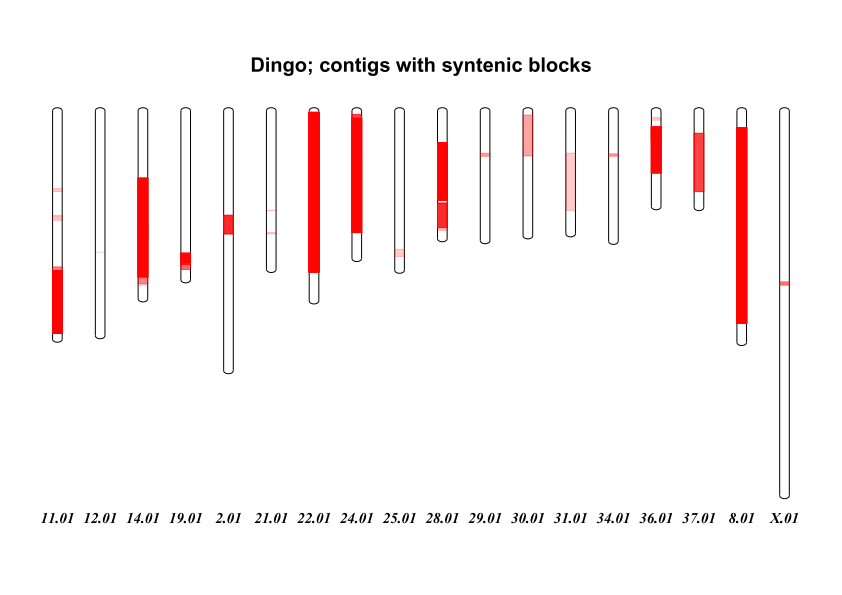

In [58]:
from reportlab.lib import colors
from reportlab.lib.units import cm

            
chr_diagram = BasicChromosome.Organism(output_format="png")
chr_diagram.page_size = (29.7*cm, 21*cm)

def draw_chr(length, name, features, max_len, tel_len=1000000, default_color='rgba(255,0,0,0.2)'):
    cur_chromosome = BasicChromosome.Chromosome(name.replace("SANDYCHR", ""))
    cur_chromosome.title_size = 15
    cur_chromosome.scale_num = max_len + 2 * tel_len


    start = BasicChromosome.TelomereSegment()
    start.scale = tel_len
    cur_chromosome.add(start)

    body = BasicChromosome.AnnotatedChromosomeSegment(length, features, default_feature_color=colors.toColor(default_color))
    body.scale = length
    cur_chromosome.add(body)

    end = BasicChromosome.TelomereSegment(inverted=True)
    end.scale = tel_len
    cur_chromosome.add(end)
    
    return cur_chromosome

max_len = max([x[1] for x in contigs])
for contig, l, features in contigs:
    print(l)
    chr_diagram.add(draw_chr(length=l,max_len=max_len, name=contig, features=features))

chr_diagram.draw(os.path.join(constants.image_out_dir, "dingoblocks.png"), "Dingo; contigs with syntenic blocks")
Image(os.path.join(constants.image_out_dir, "dingoblocks.png"))

In [26]:
def make_synteny_plot(cont_file):
    scaffolding_data = pd.read_csv(cont_file)
    scaffolding_data["assembly"] = scaffolding_data["assembly"].map(lambda x: x.replace(".fasta",""))

    metadata = pd.read_csv(os.path.join(data_dir, "assemblies.tsv"), delimiter="\t", names=["Iteration", "Organism", "Genome", "Stage", "Tools"])
    metadata.Genome = metadata.Genome.map(lambda x: x.replace('.fasta', ''))
    agg_data = pd.merge(scaffolding_data, metadata, left_on="assembly", right_on="Genome")

    colour_map = {'Assembly': 'grey', 'Initial assembly': 'grey', 'Mapping': 'grey', 'Gapfilling': 'grey', 'Fixing': 'grey', 'Polishing': 'grey', 'Reduction': 'grey', 'Scaffolding': 'C1', 'Tidying': 'grey'}

    palette = {}
    for row in agg_data.to_records():
        palette[row[4]] = colour_map[row[7]]

    synt_improv = sns.catplot(data=agg_data, x="Iteration", y="valid", kind="bar", palette=palette)
    synt_improv.set_axis_labels("Iteration", "Syntenic blocks")


# Sandy

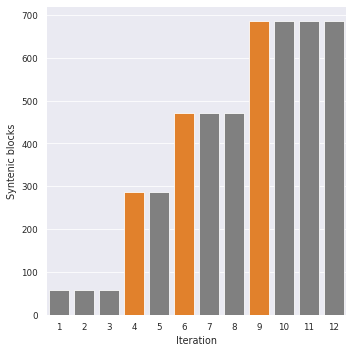

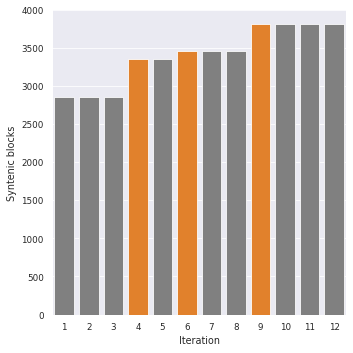

In [34]:
# With min. length of 5
make_synteny_plot(os.path.join(data_dir, "sandy", "synteny_ste08_100bp.csv"))

# With min. length of 2
make_synteny_plot(os.path.join(data_dir, "sandy", "synteny_ste08_100bp_pairs.csv"))

# Starling

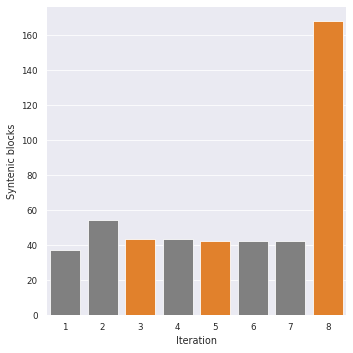

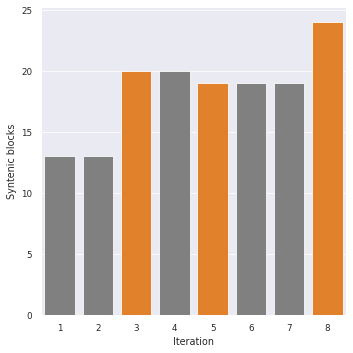

In [32]:
make_synteny_plot(os.path.join(data_dir, "starling", "synteny",  "deduce_contiguity_fast.csv"))
make_synteny_plot(os.path.join(data_dir, "starling", "synteny",  "deduce_contiguity_minimised_fast.csv"))

# Tiger snake

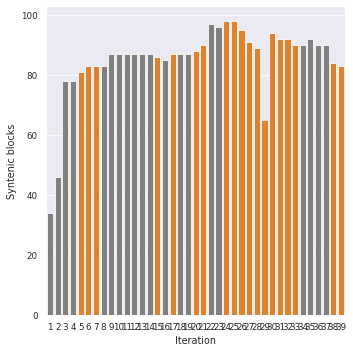

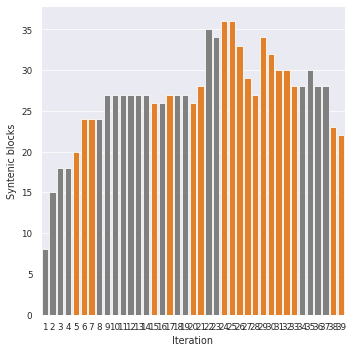

In [25]:
make_synteny_plot(os.path.join(data_dir, "tigersnake", "synteny", "deduce_contiguity.csv"))
make_synteny_plot(os.path.join(data_dir, "tigersnake", "synteny", "deduce_contiguity_minimised.csv"))